# Setup

## Installations

In [1]:
! pip install datasets transformers[sentencepiece]

## Libraries

In [2]:
from datasets import load_dataset

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

import textwrap

from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from keras.preprocessing import sequence
from keras.utils import np_utils

# Emotions Dataset

https://huggingface.co/datasets/emotion

## Load

In [3]:
raw_datasets = load_dataset("emotion")

Using custom data configuration default
Reusing dataset emotion (/root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
raw_datasets['test'].features

{'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], names_file=None, id=None),
 'text': Value(dtype='string', id=None)}

In [6]:
label_text = {i: label for i, label in enumerate(raw_datasets['test'].features['label'].names)}
label_text

{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}

## To Pandas

In [7]:
df = {}
for dataset in ['train', 'validation', 'test']:
  df[dataset] = pd.DataFrame.from_records(zip(raw_datasets[dataset]['text'], 
                                              raw_datasets[dataset]['label']), 
                                          columns=['text', 'label'])
  
df['train'].sample(5)

,text,label
329,i love wearing new shoes i just feel so glamou...,1
13405,i feel frightened to be a citizen of india whe...,4
1692,i have said this before being a mom has made m...,4
15141,i have been absolutely useless written about n...,1
7813,i know that i do not feel repressed or a priso...,0


## Some Examples

In [8]:
for _, (text, label) in df['train'].sample(10).iterrows():
  print('\n'.join(textwrap.wrap(text, 100)))
  print(f'-> {label_text[label]}\n')

im beginning to feel my way around the systems and im very impressed with the overall level of
automation and control that goes into making memset what it is
-> surprise

i had a sudden feeling of missed opportunity here i could have asked how their evening was going
-> sadness

i could have just kept going but i could tell that she was feeling really defeated and needed a
friend
-> sadness

i always feel horny when im done but its definitely a large flaccid and my penis is sleepy and hangs
low
-> love

i really hope you like my card and feel inspired to make christmas cards and a href http
papermakeupstamps
-> joy

i lived off lemon bars for a few weeks and then this weekend ate and ate and ate and it was all
horrible food and now i feel and look and am horrible
-> sadness

im feeling productive and brave
-> joy

i am sorry to hear that the assessment procedure conducted by atoshealthcare left you feeling
humiliated and poorly represented
-> sadness

i feel like i should have actively

## Class Distribution

In [9]:
for name, dataset in df.items():
  print(name)
  print(dataset['label'].map(label_text).value_counts())

train
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: label, dtype: int64
validation
joy         704
sadness     550
anger       275
fear        212
love        178
surprise     81
Name: label, dtype: int64
test
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: label, dtype: int64


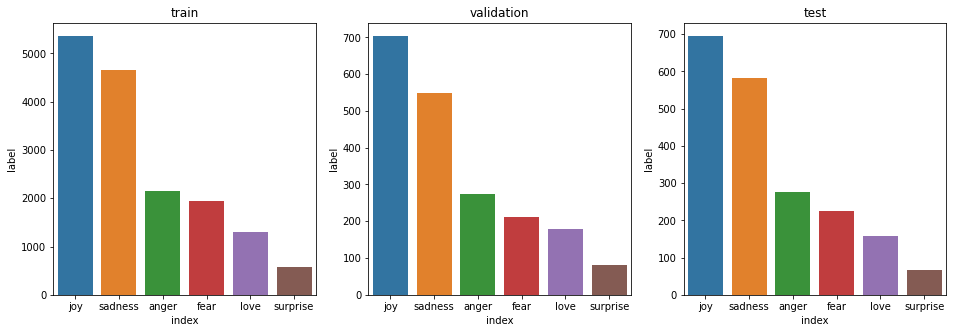

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
for i, (name, dataset) in enumerate(df.items()):
  sns.barplot(
    data=dataset['label'].map(label_text).value_counts().to_frame().reset_index(),
    x="index",
    y="label",
    ax = ax[i]
  )
  ax[i].set_title(name)

## OneHot Encoding

In [11]:
y_train = np_utils.to_categorical(df['train']['label'])
y_test = np_utils.to_categorical(df['test']['label'])
num_classes = y_test.shape[1]

In [12]:
print(y_train.shape, y_test.shape)
print(y_train[:4])

(16000, 6) (2000, 6)
[[1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0.]]


# Embeddings

_"You shall know a word by the company it keeps"_ , [J. R. Firth](https://en.wikipedia.org/wiki/John_Rupert_Firth)

- Standford's [GloVe](https://en.wikipedia.org/wiki/GloVe_(machine_learning))
- Google's [Word2Vec](https://en.wikipedia.org/wiki/Word2vec)

<img src="https://www.tensorflow.org/images/linear-relationships.png"/>

## Download GloVe

In [13]:
! curl -LO http://nlp.stanford.edu/data/glove.6B.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0   308    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0   345    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  822M  100  822M    0     0  5144k      0  0:02:43  0:02:43 --:--:-- 5074k


In [14]:
! unzip glove.6B.zip

Archive:  glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [15]:
glove_input_file = 'glove.6B.100d.txt'
word2vec_output_file = 'glove.6B.100d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 100)

## Load GloVe

In [16]:
filename = 'glove.6B.100d.txt.word2vec'
model_embedding = KeyedVectors.load_word2vec_format(filename, binary=False)

## Vector Arithmetics

(king - man) + woman = ?

In [17]:
model_embedding.most_similar(positive=['woman', 'king'], negative=['man'], topn=1)

[('queen', 0.7698541283607483)]

(france - paris) + madrid = ?

In [18]:
model_embedding.most_similar(positive=['madrid', 'france'], negative=['paris'], topn=1)

[('spain', 0.8428043723106384)]

(walking - walked) + swam = ?

In [19]:
model_embedding.most_similar(positive=['swam', 'walking'], negative=['walked'], topn=1)

[('swimming', 0.706767201423645)]

❓ Try some more word arithmetics.

Share fun ones on the chat!

## Encode

### A word

In [20]:
model_embedding.get_vector("eurostat")

array([ 0.2567  , -0.73169 ,  1.0037  ,  0.023329, -0.42895 , -0.42006 ,
       -0.26833 ,  0.68603 ,  1.4688  ,  0.28588 , -0.46718 , -0.92882 ,
        0.42914 ,  0.32218 ,  0.06615 ,  1.4683  ,  0.66255 , -0.11992 ,
        0.48364 , -0.53722 , -0.34681 ,  0.27864 , -0.1138  ,  0.76868 ,
       -0.29473 , -1.4981  , -0.19384 ,  0.51229 , -0.61332 ,  0.082637,
        0.74188 , -1.631   , -0.98953 ,  0.42431 ,  0.11131 ,  0.050107,
        0.95665 ,  0.57646 ,  0.79646 , -1.0923  , -0.095872,  0.20961 ,
       -1.3221  ,  0.49411 , -1.2532  , -0.20519 ,  0.29279 , -1.5897  ,
       -0.43074 ,  0.51698 ,  1.3758  , -0.39212 , -0.25636 ,  0.22969 ,
       -1.4172  , -0.63279 , -0.55148 ,  0.98233 ,  0.28182 ,  0.81631 ,
        0.57326 , -0.78969 , -0.75018 ,  0.45705 , -0.3261  ,  0.49271 ,
       -1.2889  , -0.058695,  1.7851  , -0.35478 ,  0.071281,  0.82326 ,
       -0.16368 , -0.11437 ,  0.88877 , -0.96364 , -0.59988 ,  0.49989 ,
       -1.5707  , -0.13491 , -0.13789 ,  0.76033 , 

### A sentence

In [21]:
sentence = "it is a pleasure to teach you some natural language processing"
sentence_embedded = np.array([model_embedding.get_vector(word) for word in sentence.split()])
print(sentence_embedded.shape)

(11, 100)


### A dataset

In [22]:
X_train_emb = [np.array([model_embedding.get_vector(word) for word in sentence.split() if word in model_embedding.vocab]) for sentence in df['train']['text'].values]
X_test_emb = [np.array([model_embedding.get_vector(word) for word in sentence.split() if word in model_embedding.vocab]) for sentence in df['test']['text'].values]

In [23]:
print(len(X_train_emb))
print(X_train_emb[0].shape)

16000
(4, 100)


## Padding

In [24]:
max_tweet_length = 20 

X_train_emb = sequence.pad_sequences(X_train_emb, maxlen=max_tweet_length) 
X_test_emb = sequence.pad_sequences(X_test_emb, maxlen=max_tweet_length) 

X_train_emb = np.stack(X_train_emb)
X_test_emb = np.stack(X_test_emb)

In [25]:
print(X_train_emb.shape)
print(X_test_emb.shape)

(16000, 20, 100)
(2000, 20, 100)


# Classification

## 1D-Convolution

In [26]:
def cnn():
  model = keras.Sequential([
    layers.Conv1D(128, (2), padding='same', activation='relu', strides=1, input_shape=(X_train_emb.shape[1:])),
    layers.MaxPool1D(pool_size=(2)),
    layers.Dropout(0.4),

    layers.Conv1D(256, (2), padding='same', activation='relu'),
    layers.MaxPool1D(pool_size=(2)),
    layers.Dropout(0.4),

    layers.Conv1D(256, (2), padding='same', activation='relu'),
    layers.GlobalMaxPooling1D(),

    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [27]:
model = cnn()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 20, 128)           25728     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 128)           0         
_________________________________________________________________
dropout (Dropout)            (None, 10, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 256)           65792     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 256)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 256)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 256)            1

In [28]:
%%time
model = cnn()

early_stopping = callbacks.EarlyStopping(
    min_delta=0,
    patience=10,
    restore_best_weights=True,
)

history = model.fit(
    X_train_emb,
    y_train,
    validation_split=0.15,
    epochs=100,
    batch_size=512,
    verbose=1,
    callbacks=[early_stopping])

Epoch 1/100
27/27 [==============================] - 12s 22ms/step - loss: 1.6413 - accuracy: 0.3168 - val_loss: 1.6458 - val_accuracy: 0.3029
Epoch 2/100
27/27 [==============================] - 0s 10ms/step - loss: 1.6084 - accuracy: 0.3275 - val_loss: 1.6395 - val_accuracy: 0.3271
Epoch 3/100
27/27 [==============================] - 0s 10ms/step - loss: 1.6009 - accuracy: 0.3236 - val_loss: 1.6183 - val_accuracy: 0.3221
Epoch 4/100
27/27 [==============================] - 0s 11ms/step - loss: 1.5908 - accuracy: 0.3304 - val_loss: 1.6080 - val_accuracy: 0.3342
Epoch 5/100
27/27 [==============================] - 0s 11ms/step - loss: 1.5861 - accuracy: 0.3363 - val_loss: 1.5963 - val_accuracy: 0.3425
Epoch 6/100
27/27 [==============================] - 0s 11ms/step - loss: 1.5696 - accuracy: 0.3533 - val_loss: 1.5488 - val_accuracy: 0.3713
Epoch 7/100
27/27 [==============================] - 0s 11ms/step - loss: 1.5407 - accuracy: 0.3810 - val_loss: 1.4871 - val_accuracy: 0.4404
Epoch

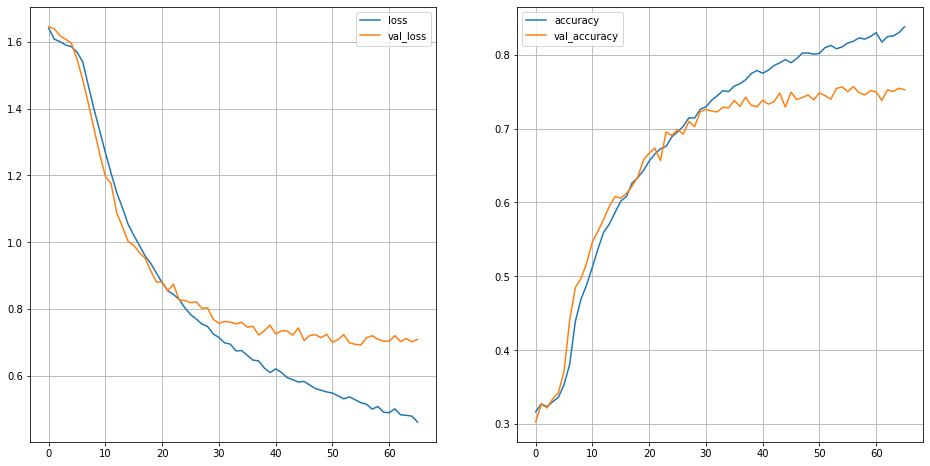

CNN Error: 25.05%


In [29]:
df_history = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

cut_first_n = 0
df_history.loc[cut_first_n:, ['loss', 'val_loss']].plot(ax=ax[0])
df_history.loc[cut_first_n:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].grid(which='both')
ax[1].grid(which='both')
plt.show()

scores = model.evaluate(X_test_emb, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

## LSTM

In [30]:
def lstm():
  model = keras.Sequential([
    layers.LSTM(128, return_sequences=True, activation='tanh', input_shape=(X_train_emb.shape[1:])),
    layers.Dropout(0.6),

    layers.BatchNormalization(),
    layers.LSTM(128, return_sequences=True, activation='tanh'),
    layers.Dropout(0.6),

    layers.BatchNormalization(),
    layers.LSTM(128),
    layers.Dropout(0.4),
    layers.Dense(64),
    layers.Dropout(0.4),
    layers.Dense(6, activation='softmax')])

  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

In [31]:
model = lstm()
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 128)           117248    
_________________________________________________________________
dropout_8 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 128)           512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 128)           131584    
_________________________________________________________________
dropout_9 (Dropout)          (None, 20, 128)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 20, 128)           512       
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)              

In [32]:
%%time
model = lstm()

early_stopping = callbacks.EarlyStopping(
    min_delta=0,
    patience=10,
    restore_best_weights=True,
)

history = model.fit(
    X_train_emb,
    y_train,
    validation_split=0.15,
    epochs=200,
    batch_size=512,
    verbose=1,
    callbacks=[early_stopping])

Epoch 1/200
27/27 [==============================] - 5s 54ms/step - loss: 1.6894 - accuracy: 0.3049 - val_loss: 1.6296 - val_accuracy: 0.3204
Epoch 2/200
27/27 [==============================] - 0s 17ms/step - loss: 1.5947 - accuracy: 0.3537 - val_loss: 1.5869 - val_accuracy: 0.3296
Epoch 3/200
27/27 [==============================] - 0s 18ms/step - loss: 1.5514 - accuracy: 0.3868 - val_loss: 1.5765 - val_accuracy: 0.3871
Epoch 4/200
27/27 [==============================] - 0s 17ms/step - loss: 1.5201 - accuracy: 0.4047 - val_loss: 1.5611 - val_accuracy: 0.3471
Epoch 5/200
27/27 [==============================] - 0s 18ms/step - loss: 1.4860 - accuracy: 0.4220 - val_loss: 1.5247 - val_accuracy: 0.4300
Epoch 6/200
27/27 [==============================] - 0s 17ms/step - loss: 1.4613 - accuracy: 0.4286 - val_loss: 1.5123 - val_accuracy: 0.4208
Epoch 7/200
27/27 [==============================] - 0s 17ms/step - loss: 1.4285 - accuracy: 0.4423 - val_loss: 1.4953 - val_accuracy: 0.3996
Epoch 

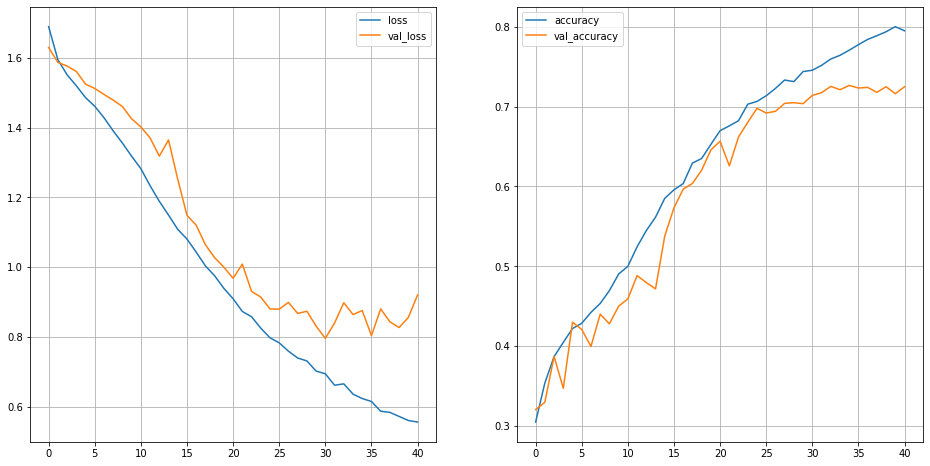

LSTM Error: 29.00%


In [33]:
df_history = pd.DataFrame(history.history)
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

cut_first_n = 0
df_history.loc[cut_first_n:, ['loss', 'val_loss']].plot(ax=ax[0])
df_history.loc[cut_first_n:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
ax[0].grid(which='both')
ax[1].grid(which='both')
plt.show()

scores = model.evaluate(X_test_emb, y_test, verbose=0)
print("LSTM Error: %.2f%%" % (100-scores[1]*100))

# Confusion Matrix

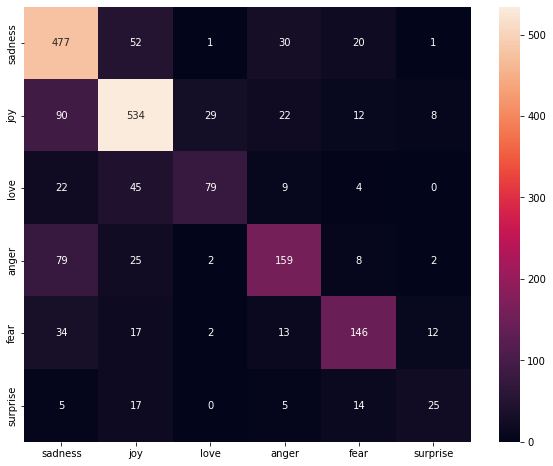

In [34]:
fig, ax = plt.subplots(figsize=(10, 8))

cm = confusion_matrix(np.argmax(y_test, axis=1), 
                      np.argmax(model.predict(X_test_emb), axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax)

ticks = np.arange(0.5,6.5,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)

ax.set_xticklabels(label_text.values())
ax.set_yticklabels(label_text.values())

plt.show()

❓ Try out the model

In [46]:
sentence = 'over the last decade global warming has accelerated'

sentence = [np.array([model_embedding.get_vector(word) for word in sentence.split()])]

sentence = sequence.pad_sequences(sentence, maxlen=max_tweet_length) 

label_text[np.argmax(model.predict(sentence)[0])]

'fear'